In [ ]:
import cupy as cp


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
from scipy.fftpack import fft2, ifft2

from matplotlib.animation import FFMpegWriter

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D

from scipy.integrate import simps
from scipy.integrate import trapz
from numpy.fft import fft2, ifft2

from matplotlib import animation
from matplotlib.animation import FuncAnimation

#import cupyimg.scipy.ndimage as ndi  # GPU-accelerated image operations


import time

import random

In [ ]:
# @title Animate
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter

def animate(arrayWF, pdf=False, Range_=35, fps=30, Complex=False, TwoD=False):
    x_min, x_max = 500 - Range_, 500 + Range_
    y_min, y_max = 500 - Range_, 500 + Range_

    if pdf:
        Str = 'pdf'
    else:
        Str = 'wf' if not Complex else 'complex_wf'

    # Convert CuPy array to NumPy if needed
    if isinstance(arrayWF[0], cp.ndarray):
        arrayWF = [cp.asnumpy(frame) for frame in arrayWF]

    fig = plt.figure()

    if pdf:
        arrayWF = np.abs(arrayWF)**2
    else:
        arrayWF = arrayWF

    if TwoD:
        ax = plt.subplot(111)
        num_levels = 100
        contour = plt.contourf(arrayWF[0], cmap='viridis', levels=num_levels, extend='both')
        colorbar = plt.colorbar(contour)
    else:
        ax = fig.add_subplot(111, projection='3d')

    def update(frame):
        if TwoD:
            ax.clear()
            contour = plt.contourf(arrayWF[frame][x_min:x_max, y_min:y_max], cmap='viridis', levels=num_levels, extend='both')
        else:
            ax.clear()
            submatrix_t = (arrayWF[frame][x_min:x_max, y_min:y_max])
            x_values = np.arange(submatrix_t.shape[0]) + x_min
            y_values = np.arange(submatrix_t.shape[1]) + y_min
            X, Y = np.meshgrid(x_values, y_values)
            surface = ax.plot_surface(X, Y, submatrix_t, cmap='viridis')
            ax.set_xlabel('X-axis')
            ax.set_ylabel('Y-axis')
            ax.set_zlabel('Density')
            ax.set_title(f'Time Step: {frame}')

    ani = FuncAnimation(fig, update, frames=len(arrayWF), repeat=False, interval=10)
    writer = FFMpegWriter(fps=fps)
    ani.save(f'animation_{Str}_{len(arrayWF)}{"_2D" if TwoD else ""}.mp4', writer=writer)


Create a class called Particle2D:

it will have the properties:
self.space_size = 10000
self.Range = 50
self.position = [(x_position, y_position)]
self.momentum = [(x_momentum, y_momentum)]
self.charge, self.mass and self.wavefunction, self.momentum_wavefunction, self.potential.
self.x = np.linspace(-self.Range,self.Range,self.space_size )
self.y = np.linspace(-self.Range,self.Range,self.space_size )
both self.wavefunction and self.momentum_wavefunction are arrays of shape (self.space_size, self.space_size)
Now it has to have the following functions:
calculate_total_energy, calculate_T, calculate_V, calculate_Expected_X, calculate_Expected_P, calculate_Expected_E.
for every function property, use self.x and self.y as the x,y of every f(x,y)
Now the important functions:

define collapse_wavefunction:
collapse wave function and take random variable from the f(x,y)=pdf_xy (x,y) = <wavefunction,wavefunction> (the inner product of the wavefunction with itself) and p(x,y) = pdf_{p_x}{p_y} = <momentum_wavefunction,momentum_wavefunction> (the inner product of the momentum_wavefunction with itself). Find the random variables by taking the inverse of the integral of the pdf and generating the uniform random variable.
With these new random position x,y and momentum, update self.position and self.momentum, and round accordingly to self.space_size and self.range.
Then set the wave function to 0 everywhere and 1/self.space_size at self.position.

define update_wavefunction:
If the current self.wavefunction is none, does not have the shape of self.x and self.y, or it has 3 or less values in the array of wavefunction that are not 0: then define a gaussian wave function centered at self.position with standard deviation σ ≥ (ħ / (2√(2ln(2) * 2mE))).
Else, update the wave function by:
-i*hbar * ∂ self.wavefunction/∂t = -hbar**2 / (2*m) * gradient squared of self.wavefunction + self.Potential * self.wavefunction and solve for self.wavefunction.
Then update self.wavefunction and self.momentum_wavefunction

Using the class Particle2D I want to have 4 particles with charge interacting by electric force, that are initially described by normalized gaussian wave packets such that.
all positions are defined as:
random.seed(1)

pos1 = (np.array([(4*random.random()-2),(4*random.random()-2)]))
q1=1
pos2 = (np.array([(4*random.random()-2),(4*random.random()-2)]))
q2=0.5
pos3 = (np.array([(4*random.random()-2),(4*random.random()-2)]))
q3=-1
pos4 = (np.array([(4*random.random()-2),(4*random.random()-2)]))
q4=-0.5
All with mass 1
Then I will update the wave function w=3 times and collapse the wave functions to calculate the position of every particle and update the wave function of every particle centered at the position of the collapsed wave function. I will repeat this process 5 times.

In [ ]:
# @title Particle Class
class Particle2D:
    def __init__(self, x_position=0, y_position=0, x_momentum=0, y_momentum=0, charge=0, mass=0, scale=1e-3, potential=None, hbar=1, space_size=1000):

        self.scale = scale
        self.hbar = hbar#1.05457182e-34
        self.c = 3
        self.E = 0
        self.space_size = space_size
        self.Range = 50
        self.position = [x_position, y_position]
        self.momentum = [x_momentum, y_momentum]
        self.charge = charge
        self.mass = mass
        self.momentum_wavefunction = None
        self.potential = potential
        self.x = np.linspace(0, self.space_size - 1, self.space_size)
        self.y = np.linspace(0, self.space_size - 1, self.space_size)

        momentum_magnitude = np.sqrt(self.momentum[0]**2 + self.momentum[1]**2)
        omega = (2 * np.pi * self.hbar) / momentum_magnitude
        E = self.hbar * omega
        self.E = max(E, self.hbar/2)

        # Initialize the wave function as a Gaussian
        #sigma = self.hbar / (2 * np.sqrt(2 * np.log(2) * 2 * self.mass * self.E))
        sigma = self.scale/self.space_size

        x, y = np.meshgrid(self.x - self.position[0], self.y - self.position[1])
        self.wavefunction = np.nan_to_num(np.exp(-(x**2 + y**2) / (2 * sigma**2)) / (np.pi * sigma**2) , nan=0)
        self.wavefunction /= np.sqrt(np.sum(np.abs(self.wavefunction)**2))

        self.momentum_wavefunction = None
        self.potential = potential


    def plot_wavefunction(self, Range_, pdf=False, Complex=False, momentum=False):
        # Extract the submatrix based on the specified limits
        x_min, x_max = int(self.space_size / 2 - Range_), int(self.space_size / 2 + Range_)
        y_min, y_max = int(self.space_size / 2 - Range_), int(self.space_size / 2 + Range_)

        if momentum == False:
            wf = self.wavefunction
        elif momentum == True:
            wf = self.momentum_wavefunction

        if pdf == False:
            if Complex == False:
                submatrix = wf[x_min:x_max, y_min:y_max]
            elif Complex == True:
                submatrix = -1j*wf[x_min:x_max, y_min:y_max]
        elif pdf == True:
            submatrix = np.abs(wf[x_min:x_max, y_min:y_max])**2

        # Create meshgrid for x and y values
        x_values = np.arange(submatrix.shape[0]) + x_min
        y_values = np.arange(submatrix.shape[1]) + y_min
        X, Y = np.meshgrid(x_values, y_values)

        # Create a 3D plot
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        # Plot the surface
        ax.plot_surface(X, Y, submatrix, cmap='viridis')  # You can change the colormap to your preference

        # Set labels for the axes
        ax.set_xlabel('X-axis')
        ax.set_ylabel('Y-axis')
        if pdf == False:
            ax.set_zlabel('Ψ(x)')
            plt.title('Wavefunction')
        elif pdf == True:
            ax.set_zlabel('||Ψ(x)||^2')
            plt.title('Density')
        # Show the plot
        plt.show()

    def create_gaussian_wavefunction(self, mean, sigma):
            x, y = np.meshgrid(self.x - mean[0], self.y - mean[1])
            self.wavefunction = np.nan_to_num(np.exp(-(x**2 + y**2) / (2 * sigma**2)) / (np.pi * sigma**2), nan=0)
            self.wavefunction /= np.sqrt(np.sum(np.abs(self.wavefunction)**2))

    def calculate_T(self):
        # Calculate the kinetic energy using the Laplacian operator
        laplacian = np.gradient(np.gradient(self.wavefunction, self.x, axis=0), self.x, axis=0) + \
                    np.gradient(np.gradient(self.wavefunction, self.y, axis=1), self.y, axis=1)
        kinetic_energy = np.sum(-self.hbar**2 * laplacian / (2 * self.mass))
        return kinetic_energy

    def calculate_V(self):
        # Compute the potential energy
        if self.potential == None:
            return 0
        potential_energy = np.sum(self.potential * self.wavefunction)
        return potential_energy

    def calculate_total_energy(self):
        if self.wavefunction is None:
            # Calculate the total energy based on the given formula
            momentum_magnitude = np.sqrt(self.momentum[0]**2 + self.momentum[1]**2)
            omega = (2 * np.pi * self.hbar) / momentum_magnitude
            E = self.hbar * omega
            self.E = E

        else:
            # Calculate the kinetic and potential energy
            kinetic_energy = self.calculate_T()
            potential_energy = self.calculate_V()
            total_energy = kinetic_energy + potential_energy
            self.E = total_energy

        return self.E

    def calculate_Expected_X(self):
        # Compute the expected value of position
        expected_x = np.sum(self.x * np.abs(self.wavefunction)**2) / np.sum(np.abs(self.wavefunction)**2)
        return expected_x

    def calculate_Expected_P(self):
        # Compute the expected value of momentum
        expected_p = np.sum(self.hbar * self.momentum_wavefunction * np.conj(self.wavefunction))
        return expected_p

    def calculate_Expected_E(self):
        # Compute the expected value of total energy
        expected_energy = np.sum(self.E * np.abs(self.wavefunction)**2)
        return expected_energy

    def collapse_wavefunction(self):
        # Calculate the probability distribution functions (PDFs) for position and momentum
        pdf_x = np.abs(self.wavefunction)**2 / np.sum(np.abs(self.wavefunction)**2)
        pdf_p = np.abs(self.momentum_wavefunction)**2 / np.sum(np.abs(self.momentum_wavefunction)**2)

        # Generate random variables for position using random_variable_2D
        random_x, random_y = self.random_variable_2D(pdf_x)

        # Update self.position and self.momentum (as integers)
        self.position = [random_x, random_y]

        # Reset the wavefunction
        #self.wavefunction = np.zeros((self.space_size, self.space_size))
        #self.wavefunction[self.space_size // 2, self.space_size // 2] = 1.0 / self.space_size

        # Initialize the wave function as a Gaussian
        sigma = self.scale/self.space_size#self.hbar / 2

        x, y = np.meshgrid(self.x - self.position[0], self.y - self.position[1])
        self.wavefunction = np.nan_to_num(np.exp(-(x**2 + y**2) / (2 * sigma**2)) / (np.pi * sigma**2) , nan=0)
        self.wavefunction /= np.sqrt(np.sum(np.abs(self.wavefunction)**2))



    def random_variable_2D(self, pdf):
        n = len(pdf)
        pdf_1d = pdf.flatten()
        weights = pdf_1d / (sum(pdf_1d))
        random_index = np.random.choice(a=np.arange(0, len(weights)), p=weights)
        # Find the row and column indices in the original 2D mesh grid
        x = random_index // n
        y = random_index % n

        return x, y


    def update_wavefunction(self, delta_t = 0.01):
        if (
            self.wavefunction is None
            or self.wavefunction.shape != (self.space_size, self.space_size)
            or np.count_nonzero(self.wavefunction) < 1
        ):
            # Initialize the wave function as a Gaussian
            sigma = self.scale / self.space_size#self.hbar / (2 * np.sqrt(2 * np.log(2) * 2 * self.mass * self.E))

            x, y = np.meshgrid(self.x - self.position[0], self.y - self.position[1])
            self.wavefunction = np.nan_to_num(np.exp(-(x**2 + y**2) / (2 * sigma**2)) / (np.pi * sigma**2) , nan=0)
            self.wavefunction /= np.sqrt(np.sum(np.abs(self.wavefunction)**2))

            #self.wavefunction = np.zeros((self.space_size, self.space_size))
            #self.wavefunction[self.space_size // 2, self.space_size // 2] = 1.0 / self.space_size



        else:
            # Update the wave function using the time-dependent Schrödinger equation
            laplacian = np.nan_to_num(np.array((np.gradient(np.gradient(self.wavefunction, self.x, axis=0), self.x, axis=0)
                        + np.gradient(np.gradient(self.wavefunction, self.y, axis=1), self.y, axis=1)), dtype=complex), nan=0)

            if self.potential is not None:
                potential_term = np.nan_to_num(self.potential * self.wavefunction, nan=0)
                wf = (-1j / self.hbar) * delta_t * (-(self.hbar**2 / (2 * self.mass)) * laplacian + potential_term)

            else:
                wf = np.nan_to_num(np.asarray(self.wavefunction, dtype=complex), nan=0)
                wf -= (-1j / self.hbar) * delta_t * (-(self.hbar**2 / (2 * self.mass)) * laplacian)


            self.wavefunction = wf/(np.sqrt(np.sum(np.abs(wf)**2)))

        self.momentum_wavefunction = np.fft.fft2(self.wavefunction)

    def calculate_mean_and_stddev(self, Print=False):
        # Calculate the mean position using the wave function and position coordinates
        mean_x = np.sum(self.x * np.abs(self.wavefunction)**2)
        mean_y = np.sum(self.y * np.abs(np.transpose(self.wavefunction))**2)

        # Calculate the standard deviation in both x and y directions
        stddev_x = np.sqrt(np.sum((self.x - mean_x)**2 * np.abs(self.wavefunction)**2))
        stddev_y = np.sqrt(np.sum((self.y - mean_y)**2 * np.abs(np.transpose(self.wavefunction))**2))

        if Print == True:
            print(f'µ_x={mean_x}, µ_y={mean_y}, σ={np.sqrt(stddev_x**2 + stddev_y**2)}')

        return mean_x, mean_y, stddev_x, stddev_y


In [ ]:
# @title Plot wavefunctions
if False:
    pos = np.array([(2 * random.random() - 1), (2 * random.random() - 1)]) * 0 + 1000/2
    mom = np.array([(2 * random.random() - 1), (2 * random.random() - 1)]) * 5
    charge = 10
    mass = 1
    print(pos, mom)

    particle = Particle2D(x_position=pos[0], y_position=pos[1], x_momentum=mom[0], y_momentum=mom[1], charge=charge, mass=mass)
    for i in range(39):
        particle.update_wavefunction(delta_t=1.2)
        wf = particle.wavefunction
        print(f'∫Ψ_{i} dx = {1/particle.space_size **2 * ((np.abs(wf))**2).sum()} & x_{i}={particle.position}')
        particle.calculate_mean_and_stddev()
        Range = max(2*(500-particle.position[0]),2*(500-particle.position[1]), 20)
        particle.plot_wavefunction(Range_=Range, pdf=True)
        if i%20 == 0:
            particle.collapse_wavefunction()
            particle.plot_wavefunction(Range_=Range, pdf=True)

    particle.plot_wavefunction(Range_=Range, pdf=True)


In [ ]:
# @title Particle GPU Class
class Particle2D_GPU:
    def __init__(self, x_position=0, y_position=0, x_momentum=0, y_momentum=0, charge=0, mass=0, scale=1e-3, potential=None, hbar=1, space_size=1000):

        self.scale = scale
        self.hbar = hbar
        self.c = 3
        self.E = 0
        self.space_size = space_size
        self.Range = 50
        self.position = [x_position, y_position]
        self.momentum = [x_momentum, y_momentum]
        self.charge = charge
        self.mass = mass
        self.momentum_wavefunction = None
        self.potential = potential
        self.x = cp.linspace(0, self.space_size - 1, self.space_size)
        self.y = cp.linspace(0, self.space_size - 1, self.space_size)

        momentum_magnitude = cp.sqrt(self.momentum[0]**2 + self.momentum[1]**2)
        omega = (2 * cp.pi * self.hbar) / momentum_magnitude
        E = self.hbar * omega
        self.E = max(E, self.hbar/2)

        # Initialize the wave function as a Gaussian
        sigma = self.scale/self.space_size

        x, y = cp.meshgrid(self.x - self.position[0], self.y - self.position[1])
        self.wavefunction = cp.nan_to_num(cp.exp(-(x**2 + y**2) / (2 * sigma**2)) / (cp.pi * sigma**2) , nan=0)
        self.wavefunction /= cp.sqrt(cp.sum(cp.abs(self.wavefunction)**2))

        self.momentum_wavefunction = None
        self.potential = potential

    def plot_wavefunction(self, Range_, pdf=False, Complex=False, momentum=False):
        # Extract the submatrix based on the specified limits
        x_min, x_max = int(self.space_size / 2 - Range_), int(self.space_size / 2 + Range_)
        y_min, y_max = int(self.space_size / 2 - Range_), int(self.space_size / 2 + Range_)

        if momentum == False:
            wf = self.wavefunction
        elif momentum == True:
            wf = self.momentum_wavefunction

        if pdf == False:
            if Complex == False:
                submatrix = wf[x_min:x_max, y_min:y_max]
            elif Complex == True:
                submatrix = -1j * wf[x_min:x_max, y_min:y_max]
        elif pdf == True:
            submatrix = cp.abs(wf[x_min:x_max, y_min:y_max])**2

        # Create meshgrid for x and y values
        x_values = cp.arange(submatrix.shape[0]) + x_min
        y_values = cp.arange(submatrix.shape[1]) + y_min
        X, Y = cp.meshgrid(x_values, y_values)

        # Create a 3D plot
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        # Plot the surface
        ax.plot_surface(cp.asnumpy(X), cp.asnumpy(Y), cp.asnumpy(submatrix), cmap='viridis')  # Convert CuPy arrays to NumPy arrays for plotting

        # Set labels for the axes
        ax.set_xlabel('X-axis')
        ax.set_ylabel('Y-axis')
        if pdf == False:
            ax.set_zlabel('Ψ(x)')
            plt.title('Wavefunction')
        elif pdf == True:
            ax.set_zlabel('||Ψ(x)||^2')
            plt.title('Density')

        # Show the plot
        plt.show()

    def create_gaussian_wavefunction(self, mean, sigma):
        x, y = cp.meshgrid(self.x - mean[0], self.y - mean[1])
        self.wavefunction = cp.nan_to_num(cp.exp(-(x**2 + y**2) / (2 * sigma**2)) / (cp.pi * sigma**2), nan=0)
        self.wavefunction /= cp.sqrt(cp.sum(cp.abs(self.wavefunction)**2))

    def calculate_T(self):
        # Calculate the kinetic energy using the Laplacian operator
        laplacian = cp.gradient(cp.gradient(self.wavefunction, self.x, axis=0), self.x, axis=0) + \
                     cp.gradient(cp.gradient(self.wavefunction, self.y, axis=1), self.y, axis=1)
        kinetic_energy = cp.sum(-self.hbar**2 * laplacian / (2 * self.mass))
        return kinetic_energy.get()  # Convert CuPy array to NumPy array

    def calculate_V(self):
        # Compute the potential energy
        if self.potential is None:
            return 0
        potential_energy = cp.sum(self.potential * self.wavefunction)
        return potential_energy.get()  # Convert CuPy array to NumPy array

    def calculate_total_energy(self):
        if self.wavefunction is None:
            # Calculate the total energy based on the given formula
            momentum_magnitude = cp.sqrt(self.momentum[0]**2 + self.momentum[1]**2)
            omega = (2 * cp.pi * self.hbar) / momentum_magnitude
            E = self.hbar * omega
            self.E = E.get()  # Convert CuPy array to NumPy array

        else:
            # Calculate the kinetic and potential energy
            kinetic_energy = self.calculate_T()
            potential_energy = self.calculate_V()
            total_energy = kinetic_energy + potential_energy
            self.E = total_energy.get()  # Convert CuPy array to NumPy array

        return self.E

    def calculate_mean_and_stddev(self, Print=False):
        # Calculate the mean position using the wave function and position coordinates
        mean_x = cp.sum(self.x * cp.abs(self.wavefunction)**2)
        mean_y = cp.sum(self.y * cp.abs(cp.transpose(self.wavefunction))**2)

        # Calculate the standard deviation in both x and y directions
        stddev_x = cp.sqrt(cp.sum((self.x - mean_x)**2 * cp.abs(self.wavefunction)**2))
        stddev_y = cp.sqrt(cp.sum((self.y - mean_y)**2 * cp.abs(cp.transpose(self.wavefunction))**2))

        if Print:
            print(f'µ_x={mean_x.get()}, µ_y={mean_y.get()}, σ={cp.sqrt(stddev_x.get()**2 + stddev_y.get()**2)}')

        return mean_x, mean_y, stddev_x, stddev_y

    def calculate_Expected_X(self):
        # Compute the expected value of position
        mean_x, mean_y, _, _ = self.calculate_mean_and_stddev()
        return mean_x.get(), mean_y.get()  # Convert CuPy array to NumPy array

    def calculate_Expected_P(self):
        # Compute the expected value of momentum
        expected_p = cp.sum(self.hbar * self.momentum_wavefunction * cp.conj(self.wavefunction))
        return expected_p.get()  # Convert CuPy array to NumPy array

    def calculate_Expected_E(self):
        # Compute the expected value of total energy
        expected_energy = cp.sum(self.E * cp.abs(self.wavefunction)**2)
        return expected_energy.get()  # Convert CuPy array to NumPy array


    def random_variable_2D(self, pdf):
        n = len(pdf)
        pdf_1d = cp.asarray(pdf.flatten())
        weights = pdf_1d / cp.sum(pdf_1d)
        random_index = cp.random.choice(a=cp.arange(0, len(weights)), p=weights)
        # Find the row and column indices in the original 2D mesh grid
        x = random_index // n
        y = random_index % n

        return int(x.get()), int(y.get())  # Convert CuPy array to Python integer

    def collapse_wavefunction(self):
        # Calculate the probability distribution functions (PDFs) for position and momentum
        pdf_x = cp.abs(self.wavefunction)**2 / cp.sum(cp.abs(self.wavefunction)**2)
        pdf_p = cp.abs(self.momentum_wavefunction)**2 / cp.sum(cp.abs(self.momentum_wavefunction)**2)

        # Generate random variables for position using random_variable_2D
        random_x, random_y = self.random_variable_2D(pdf_x)

        # Update self.position and self.momentum (as integers)
        self.position = [random_x, random_y]

        # Initialize the wave function as a Gaussian
        sigma = self.scale / self.space_size  # self.hbar / 2

        x, y = cp.meshgrid(self.x - self.position[0], self.y - self.position[1])
        self.wavefunction = cp.nan_to_num(cp.exp(-(x**2 + y**2) / (2 * sigma**2)) / (cp.pi * sigma**2), nan=0)
        self.wavefunction /= cp.sqrt(cp.sum(cp.abs(self.wavefunction)**2))


    def update_wavefunction(self, delta_t=0.01):
        if (
            self.wavefunction is None
            or self.wavefunction.shape != (self.space_size, self.space_size)
            or cp.count_nonzero(self.wavefunction) < 1
        ):
            # Initialize the wave function using create_gaussian_wavefunction
            self.create_gaussian_wavefunction(self.position, self.scale / self.space_size)
        else:
            # Update the wave function using the time-dependent Schrödinger equation
            laplacian = cp.nan_to_num(cp.array(
                (cp.gradient(cp.gradient(self.wavefunction, self.x, axis=0), self.x, axis=0)
                + cp.gradient(cp.gradient(self.wavefunction, self.y, axis=1), self.y, axis=1)), dtype=complex), nan=0)

            if self.potential is not None:
                potential_term = cp.nan_to_num(self.potential * self.wavefunction, nan=0)
                wf = (-1j / self.hbar) * delta_t * (-(self.hbar**2 / (2 * self.mass)) * laplacian + potential_term)
            else:
                wf = cp.nan_to_num(cp.asarray(self.wavefunction, dtype=complex), nan=0)
                wf -= (-1j / self.hbar) * delta_t * (-(self.hbar**2 / (2 * self.mass)) * laplacian)

            self.wavefunction = wf / (cp.sqrt(cp.sum(cp.abs(wf)**2)))

        self.momentum_wavefunction = cp.fft.fft2(self.wavefunction)


In [ ]:
# @title Variables
pos = np.array([(2 * random.random() - 1), (2 * random.random() - 1)]) * 0+ 1000/2
mom = np.array([(2 * random.random() - 1), (2 * random.random() - 1)]) * 5
charge = 10
mass = 1
print(pos, mom)

charge = 4  # Charge in Coulombs
x0, y0 = pos[0]+20.5, pos[1]+20.5  # Center of the charge
space_size = 1000  # Size of the grid

[500. 500.] [-2.86118386  2.52113006]


In [ ]:
# @title Electric Potential
def electric_potential(charge, x0, y0, space_size, k=10):
  """Calculates the electric potential at a given point.

  Args:
    charge: The charge of the object.
    x0: The x-coordinate of the point.
    y0: The y-coordinate of the point.
    space_size: The size of the space in which the potential is calculated.
    k: The Coulomb constant.
    Actual k = 8.99e9 #Coulomb's constant (in Nm^2/C^2)

  Returns:
    The electric potential at the given point.
  """
  def define_potential(charge=charge, x0=x0, y0=y0, space_size=space_size, k=k):
      x = np.linspace(0, space_size -1, space_size)
      y = np.linspace(0, space_size -1, space_size)
      xx, yy = np.meshgrid(x, y)

      r = np.sqrt((xx - x0) ** 2 + (yy - y0) ** 2)

      return k * charge / r

  return define_potential()

k = 1
electric_potential1 = electric_potential(charge, x0, y0, space_size, k=3*k)
electric_potential2 = electric_potential(charge, x0, -(y0-500)+500, space_size, k=2*k)
electric_potential3 = electric_potential(charge, x0-np.sqrt(10), 500, space_size, k=k)

electric_potential = electric_potential3 #+ electric_potential2 + electric_potential1

In [ ]:
# @title plot V
num_levels = 100


# Define your contour plot
contour = plt.contourf(electric_potential, cmap='viridis', levels=num_levels, extend='both')

# Set the plot limits
plt.xlim(450, 550)
plt.ylim(450, 550)

# Add a colorbar
colorbar = plt.colorbar(contour)

# Set a label for the colorbar (if needed)
colorbar.set_label('Electric Potential')

plt.show()

In [ ]:
space_size = 1000
pos = space_size * np.array([0.5,0.5])
hbar = 1
print(pos)

particle = Particle2D_GPU(x_position=pos[0], y_position=pos[1], x_momentum=mom[0], y_momentum=mom[1], charge=charge, mass=mass, scale=1e-3, hbar=hbar, space_size=space_size)#, potential=-electric_potential)


In [ ]:
particle.create_gaussian_wavefunction(mean=pos, sigma=1)
#particle.plot_wavefunction(Range_=100, pdf=True)


$$P(r_1\in\Omega_1\ \text{and}\ r_2\in\Omega_1)=\iint_{\Omega_1\times\Omega_1} |\Psi(r_1,r_2, t)|^2 dr_1dr_2$$
$$P(r_1\in\Omega_1)=P(r_1\in\Omega_1\ \text{and} \ r_2\in\mathbb{R})=\iint_{\Omega_1\times\mathbb{R}} |\Psi(r_1,r_2, t)|^2 dr_1dr_2$$

In [ ]:
# Measure time for calculating particle.update_wavefunction(1) for 20 iterations
start_time = time.time()
Time = []
for i in range(20):
    particle.update_wavefunction(1)
    particle.plot_wavefunction(Range_=50, pdf=True)
    Time.append(time.time() - start_time)
    start_time = time.time()
    print(f"Time for iteration {i + 1}: {Time[-1]:.4f} seconds")

In [ ]:
def electric_potential_GPU(charge, x0, y0, space_size, k=10):
    """Calculates the electric potential at a given point.

    Args:
        charge: The charge of the object.
        x0: The x-coordinate of the point.
        y0: The y-coordinate of the point.
        space_size: The size of the space in which the potential is calculated.
        k: The Coulomb constant.
        Actual k = 8.99e9 #Coulomb's constant (in Nm^2/C^2)

    Returns:
        The electric potential at the given point.
    """
    def define_potential(charge=charge, x0=x0, y0=y0, space_size=space_size, k=k):
        x = cp.linspace(0, space_size - 1, space_size)
        y = cp.linspace(0, space_size - 1, space_size)
        xx, yy = cp.meshgrid(x, y)

        r = cp.sqrt((xx - x0) ** 2 + (yy - y0) ** 2)

        return k * charge / r

    return define_potential()

k = 1e-3
space_size = 1000
pos = space_size * cp.array([0.5, 0.5])
hbar = 1

electric_potential3 = electric_potential_GPU(charge, x0 - cp.sqrt(10), 0.5*space_size, space_size, k=k)
electric_potential = electric_potential3

print(pos)

particle = Particle2D_GPU(x_position=pos[0], y_position=pos[1], x_momentum=mom[0], y_momentum=mom[1], charge=charge, mass=mass, scale=1e-3, hbar=hbar, space_size=space_size, potential=-electric_potential)
particle.create_gaussian_wavefunction(mean=pos, sigma=1)

# Measure time for calculating particle.update_wavefunction(1) for 20 iterations
start_time = time.time()
Time = []
arrayWF = []
for i in range(200):
    particle.update_wavefunction(1)
    #particle.plot_wavefunction(Range_=50, pdf=True)
    arrayWF.append(particle.wavefunction)
    Time.append(time.time() - start_time)
    start_time = time.time()
    print(f"Time for iteration {i + 1}: {Time[-1]:.4f} seconds")


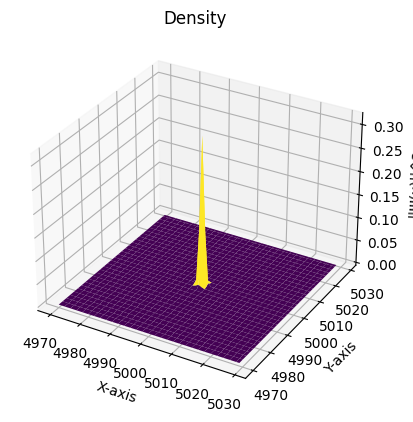

µ_x=5000.000000000001, µ_y=5000.0, σ=0.9989786092132508
0


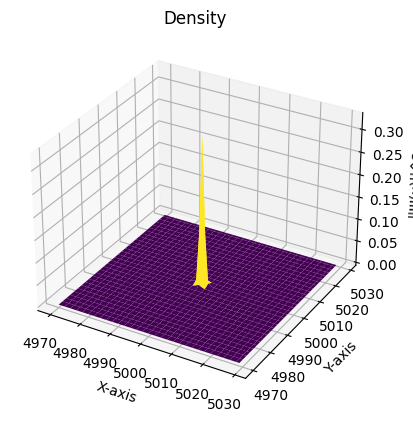

µ_x=5000.000000000001, µ_y=5000.000000000001, σ=1.0416710658665307


In [ ]:
# @title Non GPU
space_size = 10000
pos = space_size * np.array([0.5,0.5])
hbar = 1

particle = Particle2D(x_position=pos[0], y_position=pos[1], x_momentum=mom[0], y_momentum=mom[1], charge=charge, mass=mass, scale=1e-3, hbar=hbar, space_size=space_size)#, potential=-charge*electric_potential)
particle.create_gaussian_wavefunction(mean=pos, sigma=1)

particle.plot_wavefunction(Range_=30, pdf=True)
particle.calculate_mean_and_stddev(Print = True)

positions = []
arrayWF = []

for i in range(1000+1):
    particle.update_wavefunction(1)
    if i%50 == 0:
        print(i)
        particle.plot_wavefunction(Range_=30, pdf=True)
        particle.calculate_mean_and_stddev(Print = True)
    arrayWF.append(particle.wavefunction)
    #particle.plot_wavefunction(Range_=30,pdf=True)
    positions.append(particle.calculate_mean_and_stddev())

particle.plot_wavefunction(Range_=75, pdf=True)
particle.calculate_mean_and_stddev(Print = True)


In [ ]:
particle2 = Particle2D(x_position=pos[0], y_position=pos[1], x_momentum=mom[0], y_momentum=mom[1], charge=charge, mass=mass, scale=1e-3, potential=charge*electric_potential)
particle2.create_gaussian_wavefunction(mean=[500,500], sigma=1)
particle2.plot_wavefunction(Range_=50, pdf=True)
particle2.calculate_mean_and_stddev(Print = True)
positions2 = []
arrayWF2 = []
for i in range(1000+1):
    particle2.update_wavefunction(0.01)
    if i%10 == 0:
        print(i)
        particle2.plot_wavefunction(Range_=50, pdf=True)
    arrayWF2.append(particle2.wavefunction)
    #particle.plot_wavefunction(Range_=30,pdf=True)
    positions2.append(particle2.calculate_mean_and_stddev())

particle2.plot_wavefunction(Range_=50, pdf=True)
particle2.calculate_mean_and_stddev(Print = True)


In [ ]:
wf = ((np.abs(particle.wavefunction))**2)[500]
WF = (np.abs(particle.wavefunction))**2

from scipy.optimize import curve_fit

data = wf[::2]/sum(wf[::2])

# Define the function for a Gaussian distribution
def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))

# Estimate the initial parameters for the fit
amplitude_guess = np.max(data)
mean_guess = 250  # You mentioned the mean is 250
stddev_guess = 5  # An initial guess for the standard deviation

# Fit the Gaussian to your data
params, covariance = curve_fit(gaussian, np.arange(len(data)), data, p0=[amplitude_guess, mean_guess, stddev_guess])

# Extract the estimated standard deviation
estimated_stddev = params[2]

print("Estimated Standard Deviation:", estimated_stddev)

# Plot the original data and the fitted Gaussian curve
x = np.arange(len(wf))
fit_curve = gaussian(x, 1, 500, 2 * estimated_stddev)

plt.figure(figsize=(8, 4))
plt.plot(x, wf/(sum(2*wf[::2])), 'b-', label='Wave Function')
plt.xlim(400,600)
plt.plot(x, fit_curve/sum(fit_curve), 'r-', label='Fitted Gaussian')
plt.legend()
plt.show()

In [ ]:
# Assuming 'particle' and 'particle.wavefunction' are defined somewhere in your code

# Define the number of levels for the contour plot
num_levels = 100

# Define the number of points for the contour plot
num_points = 1000

# Define your contour plot with more levels and points
contour = plt.contourf(np.abs(particle.wavefunction)**2, cmap='viridis', levels=num_levels, extend='both', interpolation='bicubic')

# Set the plot limits
plt.xlim(400, 600)
plt.ylim(400, 600)

# Add a colorbar
colorbar = plt.colorbar(contour)

# Set a label for the colorbar (if needed)
colorbar.set_label(f'PDF $||\Psi(x,t={1500})||^2$')

plt.show()


In [ ]:
x_and_y = np.array(positions)[:,0:2]#[:50]
x, y = np.transpose(x_and_y)
r = np.sqrt((x-500)**2 + (y-500)**2)
plt.title('Position')
plt.scatter(x,y)
plt.grid()
plt.show()

In [ ]:
sns.histplot(r, kde=True, stat='density')
plt.show()
plt.plot(r)
plt.title('Displacement')
plt.show()

In [ ]:
vel = np.diff(r)
acc = np.diff(vel)

# Plot the change returns
plt.plot(vel)
plt.xlabel('Time')
plt.ylabel('Velocity')
plt.grid()
plt.show()

plt.plot(acc)
plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.grid()
plt.show()

In [ ]:
if False:
    for i, wf in enumerate(arrayWF):
      if i%5 == 0:
        print(i)
        # Define your contour plot
        contour = plt.contourf(wf, cmap='viridis', label='Real', alpha=0.5, levels=num_levels, extend='both', interpolation='bicubic')
        contourI = plt.contourf(-1j*wf, cmap='plasma', label='Imaginary', alpha=0.5, levels=num_levels, extend='both', interpolation='bicubic')

        # Set the plot limits
        plt.xlim(475, 525)
        plt.ylim(475, 525)
        # Add a colorbar
        colorbar = plt.colorbar(contour)
        colorbarI = plt.colorbar(contourI)

        # Set a label for the colorbar (if needed)
        colorbar.set_label(f'Wave function Re(Ψ(x,t={i}))')
        colorbarI.set_label(f'Wave function Im(Ψ(x,t={i}))')

        plt.legend()


        plt.show()

        # Define your contour plot
        contour = plt.contourf(((np.abs(wf))**2), cmap='viridis', levels=num_levels, extend='both', interpolation='bicubic')
        # Set the plot limits
        plt.xlim(475, 525)
        plt.ylim(475, 525)
        # Add a colorbar
        colorbar = plt.colorbar(contour)
        # Set a label for the colorbar (if needed)
        colorbar.set_label(f'PDF ||Ψ(x,t={i})||^2')
        plt.show()
